
=== Accuracy on Test Set ===
Naive Bayes                 : 1.0000
SVM (LinearSVC, calibrated) : 1.0000
Random Forest               : 1.0000
Ensemble (NB+SVM+RF)        : 1.0000


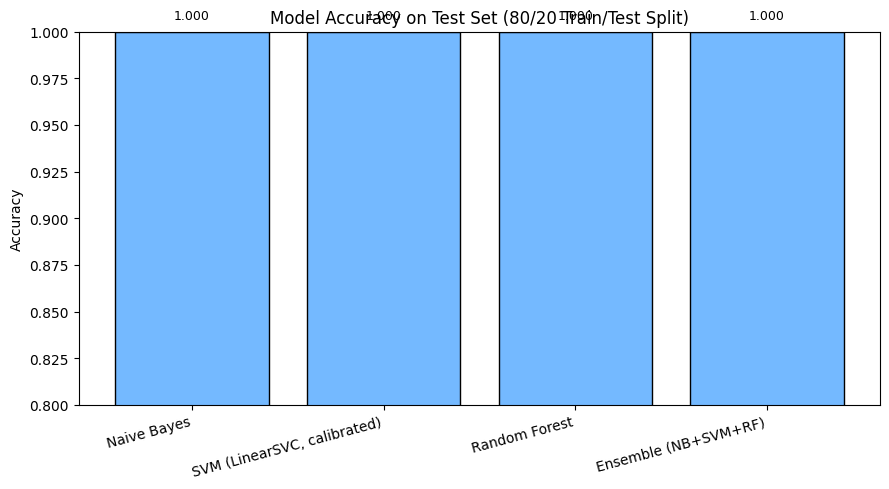

In [1]:

# --- Evaluate Models with Fixed Train/Test Split (80/20) --- 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# ======================
# 1) Load dataset
# ======================
df = pd.read_csv("siri.csv", encoding="latin-1")
df.columns = df.columns.str.lower()
df = df.rename(columns={'v1': 'label', 'v2': 'message'}) if 'v1' in df.columns else df
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df = df[["label", "message"]].dropna()

# ======================
# 2) TF-IDF Transformation
# ======================
vect = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X = vect.fit_transform(df['message'])
y = df['label'].values

# ======================
# 3) Train/Test Split (80/20)
# ======================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ======================
# 4) Define Models
# ======================
nb = MultinomialNB()
svm = CalibratedClassifierCV(LinearSVC(), cv=3)  # Provides predict_proba
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

models = {
    "Naive Bayes": nb,
    "SVM (LinearSVC, calibrated)": svm,
    "Random Forest": rf,
}

# ======================
# 5) Fit and Evaluate Models
# ======================
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)

# Ensemble Model (Naive Bayes + SVM + Random Forest)
ens = VotingClassifier(estimators=[
    ("nb", nb),
    ("svm", svm),
    ("rf", rf)
], voting="soft", weights=[1.0, 1.2, 1.0])

ens.fit(X_train, y_train)
accuracies["Ensemble (NB+SVM+RF)"] = accuracy_score(y_test, ens.predict(X_test))

# ======================
# 6) Display and Plot Results
# ======================
print("\n=== Accuracy on Test Set ===")
for k, v in accuracies.items():
    print(f"{k:28s}: {v:.4f}")

# Plot Accuracy Bar Chart
plt.figure(figsize=(9,5))
bars = plt.bar(accuracies.keys(), accuracies.values(), color="#74b9ff", edgecolor="black")
plt.ylim(0.80, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Test Set (80/20 Train/Test Split)")
plt.xticks(rotation=15, ha="right")

for b, v in zip(bars, accuracies.values()):
    plt.text(b.get_x() + b.get_width()/2, v + 0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
